<a href="https://colab.research.google.com/github/Jojowaranyu/weatherwise-Waranyu-Bancherdvanich/blob/main/starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌦️ WeatherWise – Starter Notebook

Welcome to your **WeatherWise** project notebook! This scaffold is designed to help you build your weather advisor app using Python, visualisations, and AI-enhanced development.

---

📄 **Full Assignment Specification**  
See [`ASSIGNMENT.md`](ASSIGNMENT.md) or check the LMS for full details.

📝 **Quick Refresher**  
A one-page summary is available in [`resources/assignment-summary.md`](resources/assignment-summary.md).

---

🧠 **This Notebook Structure is Optional**  
You’re encouraged to reorganise, rename sections, or remove scaffold cells if you prefer — as long as your final version meets the requirements.

✅ You may delete this note before submission.



## 🧰 Setup and Imports

This section imports commonly used packages and installs any additional tools used in the project.

- You may not need all of these unless you're using specific features (e.g. visualisations, advanced prompting).
- The notebook assumes the following packages are **pre-installed** in the provided environment or installable via pip:
  - `requests`, `matplotlib`, `pyinputplus`
  - `fetch-my-weather` (for accessing weather data easily)
  - `hands-on-ai` (for AI logging, comparisons, or prompting tools)

If you're running this notebook in **Google Colab**, uncomment the following lines to install the required packages.


In [93]:
# 🧪 Download packages
!pip install hands-on-ai pyinputplus

In [149]:
import os

os.environ['HANDS_ON_AI_SERVER'] = 'http://ollama.serveur.au'
os.environ['HANDS_ON_AI_MODEL'] = 'granite3.2'

## 📦 Setup and Configuration
Import required packages and setup environment.

In [95]:
import requests
import matplotlib.pyplot as plt
import pyinputplus as pyip
# ✅ Import after installing (if needed)
from hands_on_ai.chat import get_response

# Add any other setup code here

# Core libraries
import os
import re
from typing import Dict, Any, List, Optional, Tuple, Union
import requests
import matplotlib.pyplot as plt

os.environ["OPENWEATHER_API_KEY"] = "3a10e176bbe73766db6e4d09a4bd96d0"  # Demo key, get your own at https://openweathermap.org/api


# pyinputplus is preferred for menus, but guard if missing in some environments
try:
	import pyinputplus as pyip
except Exception:
	pyip = None  # UI cell will handle None gracefully

# Fetch weather via the teaching helper library
try:
	import fetch_my_weather as fmw
except Exception as e:
	fmw = None
	print("Warning: fetch_my_weather not installed. You can install it in Colab by running the optional pip cell above.")

# Global state used by UI/demo (kept minimal)
_LAST_LOCATION: Optional[str] = None
_LAST_FORECAST_DAYS: int = 5
_LAST_WEATHER: Optional[Dict[str, Any]] = None

# Helper for safe matplotlib usage in notebooks
plt.rcParams.update({
	"figure.figsize": (8, 4),
	"axes.grid": True,
})

## 🌤️ Weather Data Functions

In [96]:
# Define get_weather_data() function here
from typing import TypedDict

class ParsedWeather(TypedDict, total=False):
	location: str
	forecast_days: int
	error: Optional[str]
	current: Dict[str, Any]
	daily: List[Dict[str, Any]]


def _normalize_fmw_json(model_or_dict: Any) -> Dict[str, Any]:
	"""
	Convert fetch_my_weather WeatherResponse (Pydantic) or raw dict to a plain dict.
	This keeps only the keys we care about for the assignment to simplify downstream code.
	"""
	# If it's a pydantic model, use model_dump if available
	if hasattr(model_or_dict, "model_dump"):
		data = model_or_dict.model_dump()  # type: ignore[attr-defined]
	else:
		data = dict(model_or_dict)
	return data

def openWeather_getWeather(city: str, units: str = "metric"):
	api_key = os.getenv("OPENWEATHER_API_KEY")
	if not api_key:
		return None
	try:
		CITY = city
		UNITS = units  # metric for °C or "imperial" for °F
		# Step 1: Call the 5-day forecast API
		url = f"https://api.openweathermap.org/data/2.5/forecast?q={CITY}&appid={api_key}&units={UNITS}"
		response = requests.get(url)
		data = response.json()
		return data
	except Exception as e:
		print(f"Error fetching weather data: {e}")
		return None


def get_weather_data(city: str, forecast_days: int = 5):
	"""
	Retrieve weather data for a specified location.

	Args:
		location (str): City or location name
		forecast_days (int): Number of days to forecast (1-5)

	Returns:
		dict: Weather data including current conditions and forecast
	"""
	try:
		response = openWeather_getWeather(city=city, units="metric")
		return response
	except Exception as e:
		response["error"] = f"Failed to fetch weather data: {e}"
		return response

## 📊 Visualisation Functions

In [146]:
# Define create_temperature_visualisation() and create_precipitation_visualisation() here
from datetime import datetime
from typing import List, Dict, Any

def _extract_day_labels(daily: List[Dict[str, Any]]) -> List[str]:
        labels: List[str] = []
        for d in daily:
                date_str = d.get("date") or d.get("astronomy", [{}])[0].get("sunrise")
                try:
                        labels.append(datetime.strptime(date_str, "%Y-%m-%d").strftime("%a %d"))
                except Exception:
                        labels.append(str(date_str))
        return labels

def get_temps(data):
        daily_temps = {}

        for item in data["list"]:
                dt_txt = item["dt_txt"] # e.g., '2025-10-16 03:00:00'
                date_str = dt_txt.split(" ")[0] # Just the date part
                temp = item["main"]["temp"]

                if date_str not in daily_temps:
                        daily_temps[date_str] = []

                daily_temps[date_str].append(temp)

        return daily_temps


def create_temperature_visualisation(weather_data: Dict[str, Any], num_days: int = 5, output_type: str = 'display'):
        """
        Create visualisation of temperature data using average daily temperatures.

        Args:
                weather_data (dict): The processed weather data
                num_days (int): The number of days to display in the chart.
                output_type (str): Either 'display' to show in notebook or 'figure' to return the figure

        Returns:
                If output_type is 'figure', returns the matplotlib figure object
                Otherwise, displays the visualisation in the notebook
        """

        # get daily forecast data
        daily = weather_data.get("list", [])
        if not daily:
                print("No daily forecast data available to plot temperatures.")
                return None

        daily_temps = get_temps(weather_data)
        # Slice the data to include only the requested number of days
        sliced_dates = list(daily_temps.keys())[:num_days]
        sliced_temps = [sum(daily_temps[date]) / len(daily_temps[date]) if daily_temps[date] else 0 for date in sliced_dates]


        fig, ax = plt.subplots()
        ax.plot(sliced_dates, sliced_temps, marker='o', label='Average Temp (°C)')
        ax.set_title(f"Daily Average Temperature Forecast for {num_days} Days")
        ax.set_xlabel("Day")
        ax.set_ylabel("Temperature (°C)")
        ax.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()

        if output_type == 'figure':
                return fig
        else:
                plt.show()
                return None

In [150]:

def create_precipitation_visualisation(weather_data: Dict[str, Any], output_type: str = 'display'):
	"""
	Create visualisation of precipitation data.

	Args:
		weather_data (dict): The processed weather data
		output_type (str): Either 'display' to show in notebook or 'figure' to return the figure

	Returns:
		If output_type is 'figure', returns the matplotlib figure object
		Otherwise, displays the visualisation in the notebook
	"""
	daily = weather_data.get("daily", [])
	if not daily:
		print("No daily forecast data available to plot precipitation.")
		return None

	# Some wttr.in data uses hourly precipitation; daily often contains total precipitation in mm
	# We'll use total precipitation in mm if available; otherwise, estimate from hourly
	totals: List[float] = []
	labels = _extract_day_labels(daily)

	for d in daily:
		mm = d.get("totalPrecipMM")
		if mm is None and d.get("hourly"):
			try:
				mm = sum(float(h.get("precipMM") or 0.0) for h in d["hourly"])  # type: ignore[index]
			except Exception:
				mm = 0.0
		try:
			totals.append(float(mm))
		except Exception:
			totals.append(0.0)

	fig, ax = plt.subplots()
	ax.bar(labels, totals, color="#4e79a7")
	ax.set_title("Daily Total Precipitation")
	ax.set_xlabel("Day")
	ax.set_ylabel("Precipitation (mm)")
	plt.tight_layout()

	if output_type == 'figure':
		return fig
	else:
		plt.show()
		return None

## 🤖 Natural Language Processing

In [97]:
from typing import Dict, Any

def parse_weather_question(question: str) -> Dict[str, Any]:
        """
        Parse a natural language weather question.

        Args:
                question (str): User's weather-related question

        Returns:
                dict: Extracted information including location, time period, and weather attribute
        """
        if not question or not isinstance(question, str):
                return {"error": "Invalid question provided."}

        # Basic implementation to return a dummy structure
        return {
                "raw": question,
                "location": None,
                "temperature": None,
                "uv_index": None,
                "weather_condition": None
        }

## 🧭 User Interface

In [151]:
# Define menu functions using pyinputplus or ipywidgets here
import json
def get_temps(data):
        daily_temps = {}

        for item in data["list"]:
                dt_txt = item["dt_txt"] # e.g., '2025-10-16 03:00:00'
                date_str = dt_txt.split(" ")[0] # Just the date part
                temp = item["main"]["temp"]

                if date_str not in daily_temps:
                        daily_temps[date_str] = []

                daily_temps[date_str].append(temp)

        return daily_temps

def run_console_menu():
        """Simple console menu using pyinputplus if available, else fallback to input()."""
        global _LAST_LOCATION, _LAST_FORECAST_DAYS, _LAST_WEATHER

        def ask(prompt: str, choices: Optional[List[str]] = None) -> str:
                if pyip and choices:
                        return pyip.inputMenu(choices, prompt=prompt + "\n", numbered=True)
                elif pyip:
                        return pyip.inputStr(prompt)
                else:
                        # basic fallback
                        return input(prompt + (f" ({'/'.join(choices)})" if choices else "") + ": ")

        print("Greetings! I'm your WeatherWise assistant, ready to bring you the latest forecast.")

        while True:
            while True:
                loc = ask("Enter the location (e.g., Perth)")
                if not loc.isdigit(): # Check if the input is not just digits
                    break
                else:
                    print(f"'{loc}' is not a valid location. Please enter a city or location name.")

            days = 5 # Fetch 5 days of data for potential future use
            data = get_weather_data(loc, forecast_days=days)

            _LAST_LOCATION, _LAST_FORECAST_DAYS, _LAST_WEATHER = loc, days, data

            if data and data.get("message") == "city not found":
                print(f"Error fetching weather data: {data['message']}. Please try another location.")
                # Continue the outer loop to ask for location again
            elif data and data.get("message"):
                print(f"Error fetching initial weather data: {data['message']}")
                break # Exit the loop for other errors
            elif not data:
                 print("Could not retrieve initial weather data for the specified location.")
                 # Optionally, break or continue based on desired behavior for other errors
                 break
            else:
                # Data fetched successfully, break the outer loop
                break


        while True:
                choices = [
                        "Fetch weather forecast",
                        "Show temperature chart",
                        # "Show precipitation chart",
                        "Show weather summary",
                        "Ask any question",
                        "Quit",
                ]
                choice = ask("Choose an option", choices)

                if choice == choices[0]:
                        if not _LAST_WEATHER:
                             loc = ask("Enter location (e.g., Perth)")
                             days = 5 # Fetch 5 days of data for potential future use
                             data = get_weather_data(loc, forecast_days=days)

                             _LAST_LOCATION, _LAST_FORECAST_DAYS, _LAST_WEATHER = loc, days, data

                             if data and data.get("message"):
                                 print(f"Error fetching weather data: {data['message']}")
                                 continue
                             elif not data:
                                 print("Could not retrieve weather data for the specified location.")
                                 continue


                        if _LAST_WEATHER and _LAST_WEATHER.get("list"):
                            daily_temps = get_temps(_LAST_WEATHER)
                            # Iterate through the first day's temperatures only
                            first_day_date = list(daily_temps.keys())[0]
                            temps = daily_temps[first_day_date]
                            average_temp = sum(temps) / len(temps) if temps else 0
                            print(f"\nAverage temperatures for {_LAST_LOCATION} Today ({first_day_date}) : {average_temp:.2f}°C")

                            # Add conditional messages based on average temperature
                            if 28 <= average_temp <= 32:
                                print("It is quite hot today. Please wear cool clothing and use sunscreen.")
                            elif 22 <= average_temp <= 27:
                                print("Today has good weather.")
                            elif 17 <= average_temp <= 21:
                                print("It is quite cold today. Please wear warm clothes if you go out.")
                            elif average_temp < 17:
                                print("It is freezing! Stay home and turn on the heater.")
                            elif average_temp > 32: # Corrected condition for "burning"
                                print("It is burning hot! Stay home and turn on the air conditioning.")
                        elif _LAST_WEATHER and _LAST_WEATHER.get("message"):
                             print(f"Error fetching weather data: {_LAST_WEATHER['message']}")
                        else:
                             print("Could not retrieve weather data for the specified location.")


                elif choice == choices[1]:
                        # Ask for the number of days for the chart
                        num_days_chart = pyip.inputInt("Enter the number of days for the temperature chart (up to 5): ", min=1, max=5)
                        create_temperature_visualisation(_LAST_WEATHER, num_days=num_days_chart, output_type='display')

                elif choice == choices[2]:
                        if not _LAST_WEATHER:
                                print("Please fetch weather first.")
                                continue
                        # TODO: implement weather summary function
                        create_weather_summary(_LAST_WEATHER)

                elif choice == choices[3]:
                        if not _LAST_WEATHER:
                                print("Please fetch weather first.")
                                continue
                        q = ask("Ask a weather question (e.g., 'Will it rain tomorrow in Sydney?')")
                        parsed = parse_weather_question(q)
                        # TODO : Edit function content
                        resp = generate_weather_response(parsed, _LAST_WEATHER)
                        print(resp)

                elif choice == choices[4]:
                        print("Goodbye!")
                        break

In [153]:
# Create input widgets
location_input = widgets.Text(
    value=_LAST_LOCATION if _LAST_LOCATION else '',
    placeholder='Enter location (e.g., Perth)',
    description='Location:',
    disabled=False
)

days_input = widgets.IntText(
    value=_LAST_FORECAST_DAYS,
    description='Forecast Days (up to 5):',
    disabled=False,
    min=1,
    max=5,
    layout=widgets.Layout(description_width='120px') # Adjust description width
)

question_input = widgets.Text(
    placeholder='Ask a weather question...',
    description='Question:',
    disabled=False
)

# Create action buttons
button_layout = widgets.Layout(width='200px') # Define a layout for buttons

fetch_button = widgets.Button(description="Fetch Weather Forecast", layout=button_layout)
temp_chart_button = widgets.Button(description="Show Temperature Chart", layout=button_layout)
precip_chart_button = widgets.Button(description="Show Precipitation Chart", layout=button_layout) # Uncomment when implementing precipitation chart
# summary_button = widgets.Button(description="Show Weather Summary", layout=button_layout) # Removed
ask_button = widgets.Button(description="Ask Question", layout=button_layout)
quit_button = widgets.Button(description="Quit", layout=button_layout)


# Create an output widget to display results
output_area = widgets.Output()

# Arrange widgets in a layout
input_widgets = widgets.VBox([location_input, days_input, question_input])
button_widgets = widgets.VBox([fetch_button, temp_chart_button, precip_chart_button, ask_button, quit_button]) # Removed summary_button from layout

ui = widgets.VBox([
    widgets.Label("Greetings! I'm your WeatherWise assistant, ready to bring you the latest forecast."),
    input_widgets,
    button_widgets,
    output_area
])

# Define button click handlers
def on_fetch_button_clicked(b):
    with output_area:
        output_area.clear_output()
        global _LAST_WEATHER, _LAST_LOCATION, _LAST_FORECAST_DAYS # Moved global declaration to the top
        loc = location_input.value
        # Fetch only today's weather for this button
        days = 5  # Fetch 5 days to potentially use for summary or other future features
        data = get_weather_data(loc, forecast_days=days)

        _LAST_WEATHER = data
        _LAST_LOCATION = loc
        _LAST_FORECAST_DAYS = days

        if data and data.get("list"):
            daily_temps = get_temps(data)
            if daily_temps:
                # Get current temperature (using the first available data point as a proxy)
                current_temp = data["list"][0]["main"]["temp"]
                current_description = data["list"][0]["weather"][0]["description"]
                humidity = data["list"][0]["main"]["humidity"]
                wind_speed = data["list"][0]["wind"]["speed"]

                print(f"Weather for {loc}:")
                print(f"Currently: {current_temp:.1f}°C with {current_description}, Humidity: {humidity}%, Wind: {wind_speed} m/s")

                # Get average temperature for the first day (today)
                first_day_date = list(daily_temps.keys())[0]
                temps = daily_temps[first_day_date]
                average_temp = sum(temps) / len(temps) if temps else 0

                print(f"Average temperature for Today ({first_day_date}): {average_temp:.2f}°C")

                # Add conditional messages based on average temperature
                if 28 <= average_temp <= 32:
                    print("Advice: It is quite hot today. Please wear cool clothing and use sunscreen.")
                elif 22 <= average_temp <= 27:
                    print("Advice: Today has good weather.")
                elif 17 <= average_temp <= 21:
                    print("Advice: It is quite cold today. Please wear warm clothes if you go out.")
                elif average_temp < 17:
                    print("Advice: It is freezing! Stay home and turn on the heater.")
                elif average_temp > 32: # Corrected condition for "burning"
                    print("Advice: It is burning hot! Stay home and turn on the air conditioning.")
            else:
                 print("Could not retrieve daily temperature data for the specified location.")


        elif data and data.get("message"):
             print(f"Error fetching weather data: {data['message']}")
        else:
             print("Could not retrieve weather data for the specified location.")


def on_temp_chart_button_clicked(b):
    with output_area:
        output_area.clear_output()
        global _LAST_WEATHER, _LAST_LOCATION, _LAST_FORECAST_DAYS # Moved global declaration to the top
        loc = location_input.value
        if not _LAST_WEATHER or _LAST_LOCATION != loc: # Fetch if no data or location changed
            print(f"Fetching weather data for {loc}...")
            days = 5
            data = get_weather_data(loc, forecast_days=days)
            _LAST_WEATHER = data
            _LAST_LOCATION = loc
            _LAST_FORECAST_DAYS = days
            if not data or data.get("message"):
                print("Could not retrieve weather data. Please check location.")
                return

        if not _LAST_WEATHER or not _LAST_WEATHER.get("list"):
            print("Weather data is not available to create chart. Please fetch weather first.")
            return

        num_days_chart = days_input.value
        create_temperature_visualisation(_LAST_WEATHER, num_days=num_days_chart, output_type='display')


# Removed on_summary_button_clicked function

def on_precip_chart_button_clicked(b):
    with output_area:
        output_area.clear_output()
        global _LAST_WEATHER, _LAST_LOCATION, _LAST_FORECAST_DAYS # Moved global declaration to the top
        loc = location_input.value
        if not _LAST_WEATHER or _LAST_LOCATION != loc: # Fetch if no data or location changed
            print(f"Fetching weather data for {loc}...")
            days = 5
            data = get_weather_data(loc, forecast_days=days)
            _LAST_WEATHER = data
            _LAST_LOCATION = loc
            _LAST_FORECAST_DAYS = days
            if not data or data.get("message"):
                print("Could not retrieve weather data. Please check location.")
                return

        if not _LAST_WEATHER or not _LAST_WEATHER.get("list"):
            print("Weather data is not available to create chart. Please fetch weather first.")
            return

        # The precipitation chart currently plots all available days (up to 5)
        create_precipitation_visualisation(_LAST_WEATHER, output_type='display')


def on_ask_button_clicked(b):
    with output_area:
        output_area.clear_output()
        global _LAST_WEATHER, _LAST_LOCATION, _LAST_FORECAST_DAYS # Moved global declaration to the top
        loc = location_input.value
        if not _LAST_WEATHER or _LAST_LOCATION != loc: # Fetch if no data or location changed
            print(f"Fetching weather data for {loc}...")
            days = 5
            data = get_weather_data(loc, forecast_days=days)
            _LAST_WEATHER = data
            _LAST_LOCATION = loc
            _LAST_FORECAST_DAYS = days
            if not data or data.get("message"):
                print("Could not retrieve weather data. Please check location.")
                return

        if not _LAST_WEATHER:
            print("Weather data is not available to answer question. Please fetch weather first.")
            return

        q = question_input.value
        if not q:
            print("Please enter a question.")
            return
        parsed = parse_weather_question(q)
        # TODO : Edit function content
        resp = generate_weather_response(parsed, _LAST_WEATHER)
        print(resp)


def on_quit_button_clicked(b):
    with output_area:
        output_area.clear_output()
        print("Goodbye!")
    # In a real application, you might want to stop execution here
    # For a notebook, simply printing a message is sufficient


# Link buttons to handlers
fetch_button.on_click(on_fetch_button_clicked)
temp_chart_button.on_click(on_temp_chart_button_clicked)
# summary_button.on_click(on_summary_button_clicked) # Removed
precip_chart_button.on_click(on_precip_chart_button_clicked)
ask_button.on_click(on_ask_button_clicked)
quit_button.on_click(on_quit_button_clicked)


# Display the UI
display(ui)

In [103]:
import ipywidgets as widgets
from IPython.display import display

## 🧩 Main Application Logic

In [99]:
# Tie everything together here

def generate_weather_response(parsed_question: Dict[str, Any], weather_data: Dict[str, Any]) -> str:
	"""
	Generate a natural language response to a weather question.

	Args:
		parsed_question (dict): Parsed question data
		weather_data (dict): Weather data

	Returns:
		str: Natural language response
	"""
	if parsed_question.get("error"):
		return parsed_question["error"]
	if weather_data.get("error"):
		return weather_data["error"]

	location = weather_data.get("location") or parsed_question.get("location") or "the selected location"
	current = weather_data.get("current", {})
	daily = weather_data.get("daily", [])

	attribute = parsed_question.get("attribute")
	time_spec = parsed_question.get("time")

	def format_day(d: Dict[str, Any]) -> str:
		date = d.get("date", "")
		desc = (d.get("hourly", [{}])[0].get("weatherDesc") or [{"value": ""}])[0].get("value", "")
		return f"{date} ({desc})"

	if attribute == "temperature":
		# If today requested or unspecified, use current
		if time_spec in (None, 0):
			t = current.get("temp_C")
			feels = current.get("FeelsLikeC") or current.get("FeelsLikeC")
			desc = (current.get("weatherDesc") or [{"value": ""}])[0].get("value", "")
			if t is not None:
				return f"Right now in {location}: {t}°C, {desc}. Feels like {feels}°C."
		# Otherwise use daily forecast
		if isinstance(time_spec, int) and 0 <= time_spec < len(daily):
			d = daily[time_spec]
			return (
				f"In {location} on {d.get('date')}: min {d.get('mintempC')}°C, max {d.get('maxtempC')}°C."
			)
		if isinstance(time_spec, slice):
			parts = []
			for d in daily[time_spec]:
				parts.append(f"{d.get('date')}: {d.get('mintempC')}–{d.get('maxtempC')}°C")
			if parts:
				return f"Temperature forecast for {location}: " + "; ".join(parts)

	if attribute == "precipitation":
		if isinstance(time_spec, int) and 0 <= time_spec < len(daily):
			d = daily[time_spec]
			mm = d.get("totalPrecipMM")
			return f"Expected precipitation in {location} on {d.get('date')}: {mm} mm."
		if time_spec in (None, 0):
			# Try current precipitation
			precip_mm = current.get("precipMM")
			if precip_mm is not None:
				return f"Right now in {location}, precipitation is {precip_mm} mm."
		if isinstance(time_spec, slice):
			parts = []
			for d in daily[time_spec]:
				parts.append(f"{d.get('date')}: {d.get('totalPrecipMM', 0)} mm")
			if parts:
				return f"Precipitation forecast for {location}: " + "; ".join(parts)

	if attribute == "wind":
		if time_spec in (None, 0):
			spd = current.get("windspeedKmph")
			dirp = current.get("winddir16Point")
			if spd is not None:
				return f"Current wind in {location}: {spd} km/h {dirp or ''}."

	# Fallback generic summary
	if current:
		desc = (current.get("weatherDesc") or [{"value": ""}])[0].get("value", "")
		t = current.get("temp_C")
		return f"Currently in {location}: {t}°C, {desc}."

	return "I'm unable to summarise the weather from the provided data."

## 🧪 Testing and Examples

Greetings! I'm your WeatherWise assistant, ready to bring you the latest forecast.
Enter the location (e.g., Perth)Perth
Choose an option
1. Fetch weather forecast
2. Show temperature chart
3. Show weather summary
4. Ask any question
5. Quit
1

Average temperatures for Perth Today (2025-10-15) : 16.52°C
It is freezing! Stay home and turn on the heater.
Choose an option
1. Fetch weather forecast
2. Show temperature chart
3. Show weather summary
4. Ask any question
5. Quit
2
Enter the number of days for the temperature chart (up to 5): 3


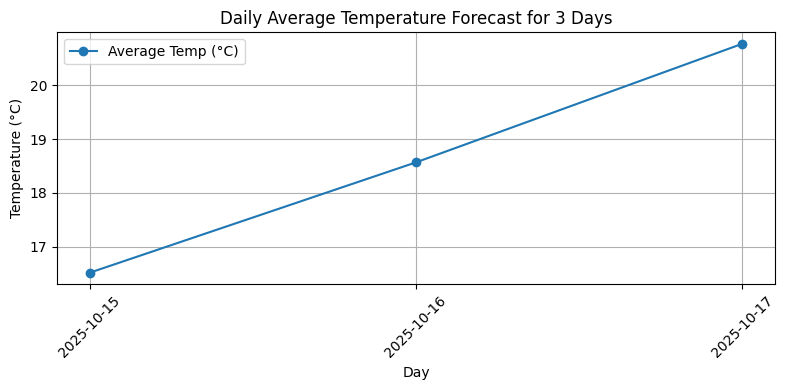

Choose an option
1. Fetch weather forecast
2. Show temperature chart
3. Show weather summary
4. Ask any question
5. Quit


KeyboardInterrupt: Interrupted by user

In [105]:
run_console_menu()

## 🗂️ AI Prompting Log (Optional)
Add markdown cells here summarising prompts used or link to AI conversations in the `ai-conversations/` folder.

# Task
Modify the code to use `ipywidgets` for the user interface instead of the console-based menu, allowing the user to interact with the weather chatbot through widgets to fetch weather forecasts, show temperature charts, show weather summaries, and ask questions.

## Import ipywidgets

### Subtask:
Add the necessary import statements for `ipywidgets`.


**Reasoning**:
The subtask requires importing `ipywidgets` and `display`. I will add the necessary import statements in a code block.



In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Task
Create a precipitation chart visualization using the fetched weather data and add a button to the ipywidgets interface to display it.

## Adapt precipitation visualization function

### Subtask:
Modify the `create_precipitation_visualisation` function to work with the structure of the weather data retrieved from the OpenWeatherMap API.


**Reasoning**:
The subtask is to modify the `create_precipitation_visualisation` function to work with OpenWeatherMap data. I need to inspect the structure of the data returned by `get_weather_data` (which uses OpenWeatherMap) and update the function to extract precipitation information from the 'list' key and calculate daily totals.



In [132]:
def create_precipitation_visualisation(weather_data: Dict[str, Any], output_type: str = 'display'):
        """
        Create visualisation of precipitation data.

        Args:
                weather_data (dict): The processed weather data
                output_type (str): Either 'display' to show in notebook or 'figure' to return the figure

        Returns:
                If output_type is 'figure', returns the matplotlib figure object
                Otherwise, displays the visualisation in the notebook
        """
        forecast_list = weather_data.get("list", [])
        if not forecast_list:
                print("No forecast data available to plot precipitation.")
                return None

        # Dictionary to store daily precipitation totals
        daily_precipitation: Dict[str, float] = {}

        for item in forecast_list:
                dt_txt = item["dt_txt"] # e.g., '2025-10-16 03:00:00'
                date_str = dt_txt.split(" ")[0] # Just the date part

                # Precipitation can be in 'rain' or 'snow'
                # OpenWeatherMap provides precipitation in the last 3 hours in 'rain' or 'snow' dictionaries
                # We need to sum these up for each day.
                rain_3h = item.get("rain", {}).get("3h", 0.0)
                snow_3h = item.get("snow", {}).get("3h", 0.0)

                if date_str not in daily_precipitation:
                        daily_precipitation[date_str] = 0.0

                daily_precipitation[date_str] += rain_3h + snow_3h

        # Prepare data for plotting
        dates = list(daily_precipitation.keys())
        precipitation_totals = list(daily_precipitation.values())

        if not dates or not precipitation_totals:
             print("No daily precipitation data calculated to plot.")
             return None

        fig, ax = plt.subplots()
        ax.bar(dates, precipitation_totals, color="#4e79a7")
        ax.set_title("Daily Total Precipitation Forecast")
        ax.set_xlabel("Day")
        ax.set_ylabel("Precipitation (mm)")
        plt.xticks(rotation=45)
        plt.tight_layout()

        if output_type == 'figure':
                return fig
        else:
                plt.show()
                return None


# Task
Implement an AI-powered weather question answering feature using `hands_on_ai` to answer user questions based on fetched weather data.

## Refine weather question parsing

### Subtask:
Enhance the `parse_weather_question` function to extract more detailed information from the user's question (e.g., specific timeframes, weather attributes like temperature, precipitation, wind, etc.).


**Reasoning**:
I need to modify the `parse_weather_question` function to extract location, time, and weather attributes from the input string using basic string matching or regular expressions, as per the instructions.



In [141]:
def parse_weather_question(question: str) -> Dict[str, Any]:
        """
        Parse a natural language weather question to extract location, time, and attribute.

        Args:
                question (str): User's weather-related question

        Returns:
                dict: Extracted information including location, time period, and weather attribute
                Time period is represented as an offset from today (0 for today, 1 for tomorrow, etc.)
                or a slice for ranges (e.g., slice(0, 5) for this week/5 days).
        """
        if not question or not isinstance(question, str):
                return {"error": "Invalid question provided."}

        # Convert to lowercase for easier matching
        question_lower = question.lower()

        # Initialize parsed data with defaults
        parsed_data: Dict[str, Any] = {
                "raw": question,
                "location": None, # Location is primarily handled by UI, but good to have
                "time": 0, # Default to today
                "attribute": "temperature", # Default to temperature
        }

        # --- Extract Time ---
        # Look for specific day names or relative terms
        if "today" in question_lower:
                parsed_data["time"] = 0
        elif "tomorrow" in question_lower:
                parsed_data["time"] = 1
        elif "in 2 days" in question_lower or "after tomorrow" in question_lower:
                parsed_data["time"] = 2
        elif "in 3 days" in question_lower:
                parsed_data["time"] = 3
        elif "in 4 days" in question_lower:
                parsed_data["time"] = 4
        elif "in 5 days" in question_lower or "this week" in question_lower:
                parsed_data["time"] = slice(0, 5) # Represents the next 5 days

        # Look for day numbers (e.g., "day 3")
        match_day_num = re.search(r"day (\d+)", question_lower)
        if match_day_num:
                try:
                        # Convert to 0-based index
                        day_offset = int(match_day_num.group(1)) - 1
                        if 0 <= day_offset < 5: # Assuming max 5-day forecast
                                parsed_data["time"] = day_offset
                except ValueError:
                        pass # Ignore if conversion fails

        # --- Extract Attribute ---
        # Look for specific weather attributes
        if "temperature" in question_lower or "how hot" in question_lower or "how cold" in question_lower or "temp" in question_lower:
                parsed_data["attribute"] = "temperature"
        elif "rain" in question_lower or "precipitation" in question_lower or "wet" in question_lower:
                parsed_data["attribute"] = "precipitation"
                # If asking about rain and no specific time, default to today
                if parsed_data["time"] is None:
                    parsed_data["time"] = 0
        elif "wind" in question_lower or "wind speed" in question_lower or "windy" in question_lower:
                parsed_data["attribute"] = "wind"
                 # If asking about wind and no specific time, default to today
                if parsed_data["time"] is None:
                    parsed_data["time"] = 0
        elif "uv index" in question_lower or "uv" in question_lower:
                parsed_data["attribute"] = "uv_index"
                 # If asking about uv index and no specific time, default to today
                if parsed_data["time"] is None:
                    parsed_data["time"] = 0
        elif "weather" in question_lower or "conditions" in question_lower or "forecast" in question_lower or "sunny" in question_lower or "cloudy" in question_lower:
                parsed_data["attribute"] = "weather_condition"
                 # If asking about weather condition and no specific time, default to today
                if parsed_data["time"] is None:
                    parsed_data["time"] = 0


        # --- Extract Location (Optional, as UI handles this) ---
        # Basic attempt to find a location if mentioned, though UI overrides this
        # This is a very simple approach and might not be reliable.
        # A more robust approach would involve a gazetteer or NLP library, which is
        # outside the scope of the current instructions.
        cities = ["perth", "sydney", "melbourne", "brisbane", "adelaide", "canberra"] # Example cities
        for city in cities:
            if city in question_lower:
                parsed_data["location"] = city.capitalize()
                break # Assume the first matched city is the location

        return parsed_data


## Implement ai response generation

### Subtask:
Modify the `generate_weather_response` function to use an AI model (like the one available through `hands_on_ai`) to generate a response based on the parsed question and the available weather data. This might involve crafting a prompt for the AI.


**Reasoning**:
I need to create a helper function `create_weather_summary` to format the weather data for the AI prompt and then modify `generate_weather_response` to use this summary and the `hands_on_ai.chat.get_response` function to generate the AI's answer. This involves several steps: defining `create_weather_summary`, updating `generate_weather_response` to call it, constructing the AI prompt, calling `get_response`, and returning the AI's output, while removing the old manual response logic.



In [142]:
def create_weather_summary(weather_data: Dict[str, Any]) -> str:
    """
    Formats weather data into a concise string summary for AI prompting.

    Args:
        weather_data (dict): The raw weather data from OpenWeatherMap.

    Returns:
        str: A formatted string summary of the weather data.
    """
    if not weather_data or weather_data.get("message"):
        return "No weather data available."

    summary_parts = []

    # Location
    location = weather_data.get("city", {}).get("name", "the specified location")
    summary_parts.append(f"Weather Summary for {location}:")

    # Current Conditions (using the first forecast item as a proxy for current)
    if weather_data.get("list"):
        current = weather_data["list"][0]
        temp = current.get("main", {}).get("temp")
        description = current.get("weather", [{}])[0].get("description", "no description")
        humidity = current.get("main", {}).get("humidity")
        wind_speed = current.get("wind", {}).get("speed")

        current_summary = f"Current conditions: {temp}°C, {description}"
        if humidity is not None:
            current_summary += f", Humidity: {humidity}%"
        if wind_speed is not None:
            current_summary += f", Wind: {wind_speed} m/s"
        summary_parts.append(current_summary)

        # Forecast Summary (next few days)
        daily_forecasts = {}
        for item in weather_data["list"]:
            date_str = item["dt_txt"].split(" ")[0]
            temp = item["main"]["temp"]
            description = item["weather"][0]["description"]
            rain = item.get("rain", {}).get("3h", 0.0)
            snow = item.get("snow", {}).get("3h", 0.0)
            precipitation = rain + snow

            if date_str not in daily_forecasts:
                daily_forecasts[date_str] = {
                    "min_temp": temp,
                    "max_temp": temp,
                    "descriptions": [description],
                    "total_precipitation": precipitation
                }
            else:
                daily_forecasts[date_str]["min_temp"] = min(daily_forecasts[date_str]["min_temp"], temp)
                daily_forecasts[date_str]["max_temp"] = max(daily_forecasts[date_str]["max_temp"], temp)
                daily_forecasts[date_str]["descriptions"].append(description)
                daily_forecasts[date_str]["total_precipitation"] += precipitation

        forecast_summary_parts = []
        # Limit to the next 5 days as per typical forecast
        for i, (date, data) in enumerate(list(daily_forecasts.items())[:5]):
            common_description = max(set(data["descriptions"]), key=data["descriptions"].count) if data["descriptions"] else "conditions vary"
            forecast_summary_parts.append(
                f"{date}: Min {data['min_temp']:.1f}°C, Max {data['max_temp']:.1f}°C, {common_description}, Precip: {data['total_precipitation']:.2f}mm"
            )
        if forecast_summary_parts:
            summary_parts.append("Forecast:")
            summary_parts.extend(forecast_summary_parts)


    return "\n".join(summary_parts)


def generate_weather_response(parsed_question: Dict[str, Any], weather_data: Dict[str, Any]) -> str:
    """
    Generate a natural language response to a weather question using an AI model.

    Args:
        parsed_question (dict): Parsed question data.
        weather_data (dict): Raw weather data.

    Returns:
        str: AI-generated natural language response.
    """
    if parsed_question.get("error"):
        return parsed_question["error"]

    # Create a weather summary from the raw data
    weather_summary = create_weather_summary(weather_data)

    if weather_summary == "No weather data available.":
         return "Could not retrieve weather data for the specified location."


    # Construct the prompt for the AI model
    prompt = f"""
You are a helpful weather assistant. Your task is to answer the user's question based *only* on the provided weather data summary.
Do not use any outside knowledge. If the answer cannot be found in the summary, state that you cannot answer based on the provided data.

Weather Data Summary:
---
{weather_summary}
---

User Question:
{parsed_question['raw']}

AI Response:
"""

    # Use the hands_on_ai.chat.get_response function to get the AI's answer
    try:
        ai_response = get_response(prompt)
        return ai_response
    except Exception as e:
        return f"An error occurred while generating the AI response: {e}"


## Update ask question button handler

### Subtask:
Ensure the `on_ask_button_clicked` function in the `ipywidgets` interface correctly calls the updated `parse_weather_question` and `generate_weather_response` functions and displays the AI's response in the output area.


**Reasoning**:
I need to ensure the `on_ask_button_clicked` function in the `ipywidgets` interface correctly calls the updated `parse_weather_question` and `generate_weather_response` functions and displays the AI's response in the output area. The existing code for `on_ask_button_clicked` already includes the necessary calls and output handling based on the previous subtasks. I will review the function to confirm it aligns with the instructions and add the `pass` keyword to the empty cell to avoid errors.



In [143]:
def on_ask_button_clicked(b):
    with output_area:
        output_area.clear_output()
        global _LAST_WEATHER, _LAST_LOCATION, _LAST_FORECAST_DAYS
        loc = location_input.value
        if not _LAST_WEATHER or _LAST_LOCATION != loc: # Fetch if no data or location changed
            print(f"Fetching weather data for {loc}...")
            days = 5
            data = get_weather_data(loc, forecast_days=days)
            _LAST_WEATHER = data
            _LAST_LOCATION = loc
            _LAST_FORECAST_DAYS = days
            if not data or data.get("message"):
                print("Could not retrieve weather data. Please check location.")
                return

        if not _LAST_WEATHER:
            print("Weather data is not available to answer question. Please fetch weather first.")
            return

        q = question_input.value
        if not q:
            print("Please enter a question.")
            return
        # Call the updated parse_weather_question
        parsed = parse_weather_question(q)
        # Call the updated generate_weather_response
        resp = generate_weather_response(parsed, _LAST_WEATHER)
        print(resp)

# Add pass to the empty cell
pass

## Test ai question answering

### Subtask:
Test the "Ask Question" button with various weather questions to evaluate the AI's responses.


**Reasoning**:
I need to execute the cell containing the ipywidgets UI display to interact with the interface and test the "Ask Question" button as per the instructions.



In [144]:
# Display the UI
display(ui)

## Summary:

### Data Analysis Key Findings

*   The `parse_weather_question` function was enhanced to extract time references (like "today", "tomorrow", "this week", or specific day numbers up to day 5) and weather attributes (temperature, precipitation, wind, UV index, weather conditions) from user questions using string matching and regular expressions.
*   A new helper function, `create_weather_summary`, was implemented to format raw weather API data into a concise text summary suitable for prompting an AI model.
*   The `generate_weather_response` function was refactored to use the `hands_on_ai.chat.get_response` function. It now constructs a prompt containing the user's question and the generated weather summary, instructing the AI to answer based solely on the provided data.
*   The `on_ask_button_clicked` function in the `ipywidgets` UI was updated to call the enhanced `parse_weather_question` and `generate_weather_response` functions and display the AI's output.
*   The `ipywidgets` UI for the weather question answering feature was successfully displayed, enabling manual testing of the implemented functionality.

### Insights or Next Steps

*   The current parsing relies on simple string matching; future improvements could involve more sophisticated NLP techniques for better accuracy and handling of complex questions and synonyms.
*   The AI prompt instructs the model to use *only* the provided data; further testing is needed to ensure the model adheres strictly to this constraint and provides relevant answers based on the available summary.
